# Projet Machine Learning

# Analyse du dataset de Plonger 

## Importation des packages

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Resumé du dataset

Lecture du csv

In [312]:
dataset = pd.read_csv('AIDA_Results_IA_Institut.csv')

Affichage des 10 premières lignes

In [313]:
dataset.head(10)

Start                        Diver Gender Discipline  Line Official Top  \
0      1        Tasos Grillakis (GRC)      M        FIM   NaN        00:00   
1      2   Antonis Papantonatos (GRC)      M        FIM   NaN        00:00   
2      3     Dimitris Koumoulos (GRC)      M        CNF   NaN        00:00   
3      4  Christos Papadopoulos (GRC)      M        CWT   NaN        00:00   
4      5           Anna Chalari (GRC)      F        CWT   NaN        00:00   
5      6        Alkisti Vouraki (GRC)      F        CWT   NaN        00:00   
6      7   Stavroula Kontorousi (GRC)      F        CWT   NaN        00:00   
7      8        Yuliya Ilkevich (BLR)      F        CWT   NaN        00:00   
8      9    Dimitris Tsigkounis (GRC)      M        CWT   NaN        00:00   
9     10     Emmanouil Marneros (GRC)      M        CWT   NaN        00:00   

   AP    RP    Card Points     Remarks       Title Event         Event Type  \
0  33  23 m  YELLOW   12.0           -  Depth Event 2016  Depth Competition   
1  55  47 m  YELLOW   38.0           -  Depth Event 2016  Depth Competition   
2  55  55 m   WHITE   55.0           -  Depth Event 2016  Depth Competition   
3  55  55 m   WHITE   55.0          OK  Depth Event 2016  Depth Competition   
4  15  15 m   WHITE   15.0          OK  Depth Event 2016  Depth Competition   
5  16  16 m   WHITE   16.0          OK  Depth Event 2016  Depth Competition   
6  20  20 m   WHITE   20.0          OK  Depth Event 2016  Depth Competition   
7  40  31 m  YELLOW   21.0  SHORT, TAG  Depth Event 2016  Depth Competition   
8  40  26 m  YELLOW   11.0  SHORT, TAG  Depth Event 2016  Depth Competition   
9  47  47 m   WHITE   47.0          OK  Depth Event 2016  Depth Competition   

          Day Category Event  
0  2016-07-17          other  
1  2016-07-17          other  
2  2016-07-17          other  
3  2016-07-17          other  
4  2016-07-17          other  
5  2016-07-17          other  
6  2016-07-17          other  
7  2016-07-17          other  
8  2016-07-17          other  
9  2016-07-17          other

In [314]:
dataset.shape # taille du dataset

(26841, 15)

In [315]:
dataset.isna().sum() # analyse du nombre de valeurs nan dans chaque colonnes 

Start                 0
Diver                 0
Gender                0
Discipline            0
Line              22147
Official Top          0
AP                    0
RP                    0
Card                  0
Points                0
Remarks               5
Title Event           0
Event Type            0
Day                   0
Category Event        0
dtype: int64

## Nettoyage et Visualisation

### Observation du nettoyage à faire 

In [316]:
dataset = dataset.drop(['Line'], axis=1)
# on retire 'Line' puique composé majoritairement de NAN

In [317]:
non_numeric_df = dataset[['Diver','Gender', 'Discipline', 'Card', 'Remarks', 'Title Event', 'Event Type', 'Day', 'Category Event']]
numeric_df = dataset[['Official Top', 'AP', 'RP', 'Points']]

In [318]:
for col in non_numeric_df.columns :
    print(col, '\n', non_numeric_df[col].value_counts(), '\n')

Diver 
 William Trubridge (NZL)    139
Georgina Miller (GBR)      135
Alexey Molchanov (RUS)     121
Alejandro Lemus (MEX)      116
Ken Kiriyama (JPN)         109
                          ... 
Yu Keunsoo (KOR)             1
Ki.Pyeong Lim (KOR)          1
Sunggwang Jung (KOR)         1
Shaun Househam (GBR)         1
Laffay Sylvain (FRA)         1
Name: Diver, Length: 4656, dtype: int64 

Gender 
 M    17434
F     9407
Name: Gender, dtype: int64 

Discipline 
 CWT     10725
FIM      8075
CNF      4813
CWTB     3228
Name: Discipline, dtype: int64 

Card 
 WHITE     19189
YELLOW     4990
RED        2524
-           138
Name: Card, dtype: int64 

Remarks 
 OK                                     8628
Ok                                     7660
-                                      2597
PEN                                    2219
No tag,rp<ap                            657
                                       ... 
DQPulling                                 1
DQ Late Start                  

on decidera d'enlever les Divers car peux interressant pour de l'IA cela pourrai biaisais, on observe plus de 1000 valeurs pour les dates ce qui ne semble pas forcément pertinent, on enlevera aussi title event car on a event type ce qui est plus intéressant on garde aussi category event

In [319]:
numeric_df 

Official Top  AP    RP Points
0            00:00  33  23 m   12.0
1            00:00  55  47 m   38.0
2            00:00  55  55 m   55.0
3            00:00  55  55 m   55.0
4            00:00  15  15 m   15.0
...            ...  ..   ...    ...
26836        09:40  57  57 m     57
26837        09:50  52  52 m     52
26838        10:00  40  40 m     40
26839        10:10  33  28 m     22
26840        10:20  30  30 m     30

[26841 rows x 4 columns]

on enlevera official top car on ne connais pas la localisation des horraires donc sur quel fuseaux il sont de plus meme si toute les données sont enregistrées sur le meme fuseaux ce ne sont pas les memes horraires selon la localisation donc un depart à 00:00 GTM sera 01:00 à Paris et encore diffenrt à New York et transformeta RP en entier

In [320]:
# on regarde si il existe des plongeur ayant un nom prenom et pays inferieur à 10 caratère
non_numeric_df[non_numeric_df['Diver'].str.len() < 10] 

Diver Gender Discipline    Card Remarks  \
2639     ()      F        CWT   WHITE      OK   
4687     ()      F        CWT  YELLOW     PEN   
5119     ()      F        CWT     RED    DQBO   
5695     ()      F        CNF   WHITE      OK   
5696     ()      F        CNF   WHITE      OK   
5697     ()      F        CWT   WHITE      OK   
7124     ()      F        FIM  YELLOW     PEN   
7782     ()      F        FIM   WHITE      OK   
7817     ()      F        CWT   WHITE      OK   
7818     ()      F        FIM   WHITE      OK   
7819     ()      F        CNF   WHITE      OK   
8508     ()      F        CWT   WHITE      OK   
8529     ()      F        CWT   WHITE      OK   
8553     ()      F        CWT  YELLOW     PEN   
8973     ()      F        CWT  YELLOW     PEN   
8989     ()      F        CWT  YELLOW     PEN   
9120     ()      F        CWT     RED    DQBO   
9156     ()      F        CNF     RED    DQBO   
9166     ()      F        CWT     RED    DQBO   
10417    ()      F        CWT  YELLOW     PEN   
10786    ()      F        CWT  YELLOW     PEN   
10787    ()      F        CNF   WHITE      OK   
10788    ()      F        FIM   WHITE      OK   
11224    ()      F        CWT   WHITE      OK   
13306    ()      F        CWT   WHITE      OK   
13343    ()      F        CWT   WHITE      OK   

                                          Title Event          Event Type  \
2639                            AIDA Pacific Cup 2002   Mixed Competition   
4687             4ème Manche Coupe d AIDA France 2004   Mixed Competition   
5119                          World Championship 2012  World Championship   
5695                               2013 Kalamata Open   Depth Competition   
5696                               2013 Kalamata Open   Depth Competition   
5697                               2013 Kalamata Open   Depth Competition   
7124               (in progress) Bizzy Blue Hole 2009         Competition   
7782                     little blue hole competition   Depth Competition   
7817                           AIDA Red Sea World Cup   Mixed Competition   
7818                           AIDA Red Sea World Cup   Mixed Competition   
7819                           AIDA Red Sea World Cup   Mixed Competition   
8508                CAFA Western Regional Competition         Competition   
8529                  CAFA National Championship 2004   Mixed Competition   
8553   4th AIDA Freediving World Championship by team   Mixed Competition   
8973                 Sony Freediver Open Classic 2003   Mixed Competition   
8989                 Sony Freediver Open Classic 2003   Mixed Competition   
9120                     AIDA CYPRUS Depth Games 2012   Depth Competition   
9156                     AIDA Cyprus Depth Games 2011   Depth Competition   
9166                     AIDA Cyprus Depth Games 2011   Depth Competition   
10417         3rd Danish Freediving Championship 2003         Competition   
10786                Mediterranean Freediving Meeting   Depth Competition   
10787                Mediterranean Freediving Meeting   Depth Competition   
10788                Mediterranean Freediving Meeting   Depth Competition   
11224          1st Portuguese Freediving Championship         Competition   
13306                 Compiled rankings for year 2000         Competition   
13343                 Compiled rankings for year 2001         Competition   

              Day      Category Event  
2639   2002-10-31               other  
4687   2004-05-06               other  
5119   2012-09-09  World Championship  
5695   2013-09-09               other  
5696   2013-09-09               other  
5697   2013-09-09               other  
7124   2009-04-21               other  
7782   2012-09-28               other  
7817   2012-08-20  World Championship  
7818   2012-08-20  World Championship  
7819   2012-08-20  World Championship  
8508   2004-05-07               other  
8529   2004-06-25               other  
8553   2004-08-12  World Championship  
89

on observe un plongeur sans nom on decide de supprimer ces lignes car on ne sait pas si il s'agit d'un seul ou plusieur plongeurs ainsi  lors de la creation des colonnes d'experiences cela pourrais biaisais le model dans le futur

In [321]:
# on regarde si il existe des dates inferieure a la taille standard des dates
non_numeric_df[non_numeric_df['Day'].str.len() < 10 ] 

Empty DataFrame
Columns: [Diver, Gender, Discipline, Card, Remarks, Title Event, Event Type, Day, Category Event]
Index: []

In [322]:
# on regarde si il existe des dates superieur a la taille standard des dates
non_numeric_df[non_numeric_df['Day'].str.len() > 10 ] 

Empty DataFrame
Columns: [Diver, Gender, Discipline, Card, Remarks, Title Event, Event Type, Day, Category Event]
Index: []

toute les dates on la meme tailles 

In [323]:
print(f"{[element for element in dataset.Day.unique()]}")

['2016-07-17', '2016-07-23', '2016-07-24', '2016-09-23', '2016-09-24', '2016-11-05', '2016-11-07', '2016-11-08', '2016-11-10', '2016-11-11', '2016-08-15', '2016-08-16', '2016-08-21', '2016-08-17', '2016-08-18', '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24', '2016-11-25', '2016-10-02', '2016-10-03', '2016-09-10', '2016-10-24', '2016-10-25', '2016-10-28', '2016-10-29', '2016-09-22', '2016-09-05', '2016-09-06', '2016-09-08', '2016-09-09', '2016-10-10', '2016-04-22', '2016-04-23', '2016-04-24', '2016-04-26', '2016-04-27', '2016-04-28', '2016-04-30', '2016-05-01', '2016-05-02', '2016-10-08', '2016-10-09', '2016-10-23', '2016-05-26', '2016-05-27', '2016-05-28', '2016-05-30', '2016-05-31', '2016-06-01', '2016-11-03', '2017-05-23', '2017-05-25', '2017-08-08', '2017-08-10', '2017-10-24', '2017-10-26', '2016-11-14', '2016-11-15', '2016-05-25', '2016-06-21', '2016-06-22', '2016-07-25', '2016-07-26', '2016-06-05', '2016-06-07', '2016-06-09', '2016-06-12', '2016-06-14', '2016

toutes les dates ont le memes formats et sont correcte

In [324]:
numeric_df[numeric_df['RP'].str.contains('-')]

Official Top  AP    RP Points
2340         00:00  70  -2 m    0.0
2343         00:00  54  -2 m    0.0
2357         00:00  51  -2 m    0.0
2364         00:00  62  -2 m    0.0
2382         00:00  70  -2 m    0.0
...            ...  ..   ...    ...
25697        12:48  70     -      -
25698        12:54  35     -      -
25699        13:00  70     -      -
25700        13:06  35     -      -
25701        13:12  65     -      -

[459 rows x 4 columns]

On garde le RP négatif pour donner une référence d'echec au programme de machine learning. \
Cependant les tirets qui ne représentent rien sont retirés en les transformant en NAN puis drop. \
On enlevera les points donc on les transformera pas afin d'eviter une perte de lignes qui seraient correct pour le reste

### Nettoyage

In [325]:
dataset = dataset[dataset['Diver'] != '()'] # on enleve les () du dataset
dataset['RP'] = dataset['RP'].replace('-', np.nan) # on remplace les - par de NaN afin de les drops
dataset['Card'] = dataset['Card'].replace('-', np.nan) # on remplace les - par de NaN afin de les drops
dataset = dataset.dropna()
dataset['RP'] = dataset['RP'].str.split(' ').str[0].astype(int) # on recupère uniquement les chiffres et on les transformes en entiers

### Visualisation graphique

In [326]:
# on créer la collonne Year afin de faires des graphiques par années
dataset['Year'] = pd.to_datetime(dataset['Day']).dt.year

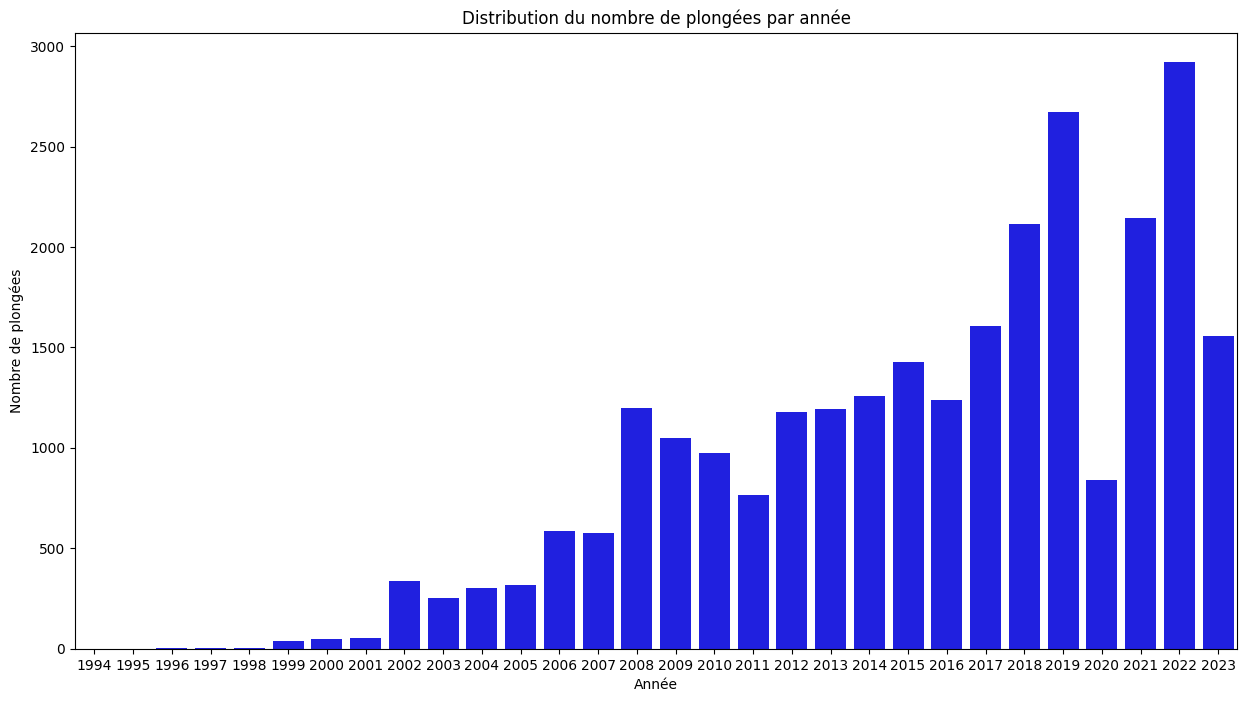

In [327]:
# Distribution du nombre de plongées par année

plt.figure(figsize=(15, 8))
sns.countplot(x='Year', data=dataset, color='blue')
plt.title('Distribution du nombre de plongées par année')
plt.xlabel('Année')
plt.ylabel('Nombre de plongées')
plt.show()

On peut voir une augmentation globale du nombre du plongées au file des années. C'est surement dû a une augmentation graduelle de la popularité de l'apnée. Les deux seul anomlies dans la tendance sont 2020 qui correspond à l'année du covid-19 et 2023 qui n'est pas finis donc il est normal que la quantité de plongées soit plus basse.

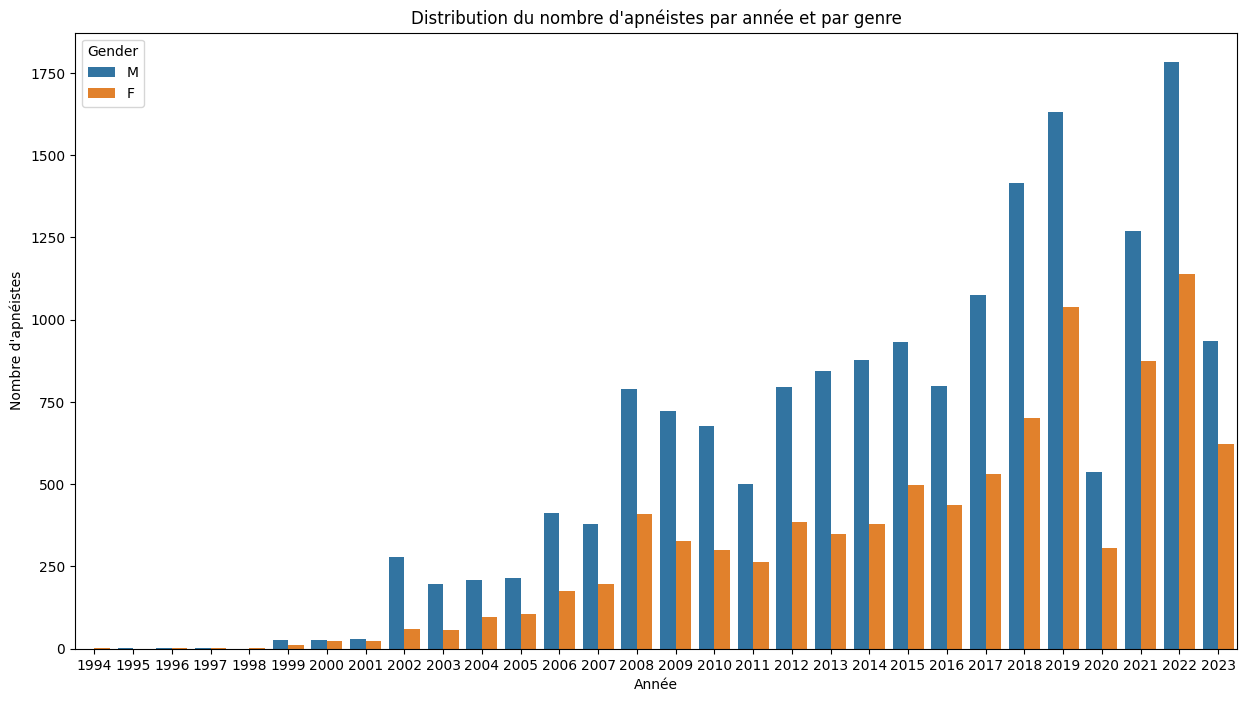

In [328]:
# Distribution du nombre d'apnéistes par année et par genre

plt.figure(figsize=(15, 8))
sns.countplot(x='Year', hue='Gender', data=dataset)
plt.title('Distribution du nombre d\'apnéistes par année et par genre')
plt.xlabel('Année')
plt.ylabel('Nombre d\'apnéistes')
plt.show()

On retrouve la tendance du premier graph sur celui-ci. Il montre la différence homme/femme, on observe un majorité d'homme dans ce sport, presque le double d'homme que de femme.

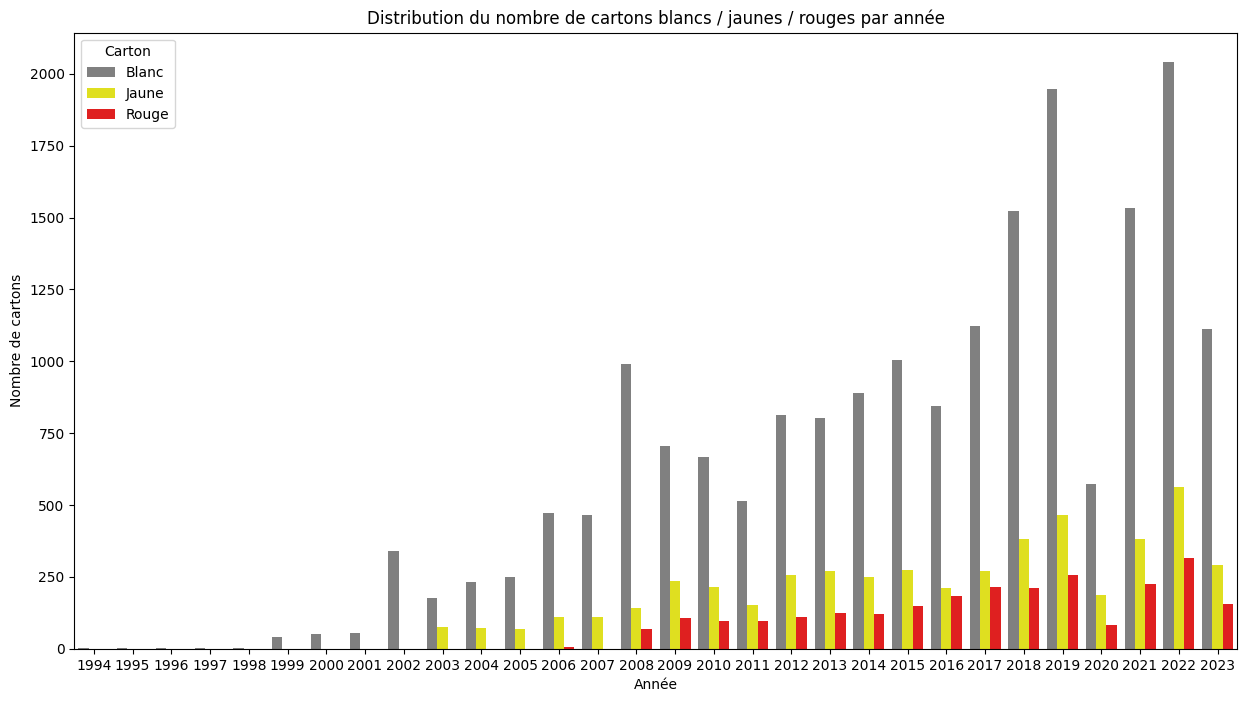

In [329]:
# Distribution du nombre de cartons blancs/jaunes/rouges par année

plt.figure(figsize=(15, 8))
# Define a color palette with white, yellow, and red
colors = ["gray", "yellow", "red"]
sns.countplot(x='Year', hue='Card', data=dataset, hue_order=['WHITE', 'YELLOW', 'RED'],palette=colors)
plt.title("Distribution du nombre de cartons blancs / jaunes / rouges par année")
plt.xlabel('Année')
plt.ylabel('Nombre de cartons')
plt.legend(title='Carton', loc='upper left', labels=['Blanc', 'Jaune', 'Rouge'])
plt.show()

Ce graph reprend la tendance des précédents mais analyse les résulats des apnéistes. La grande majoritée sont des plongées réussies mais quelques unes sont des fautes de performance ou de protocole.

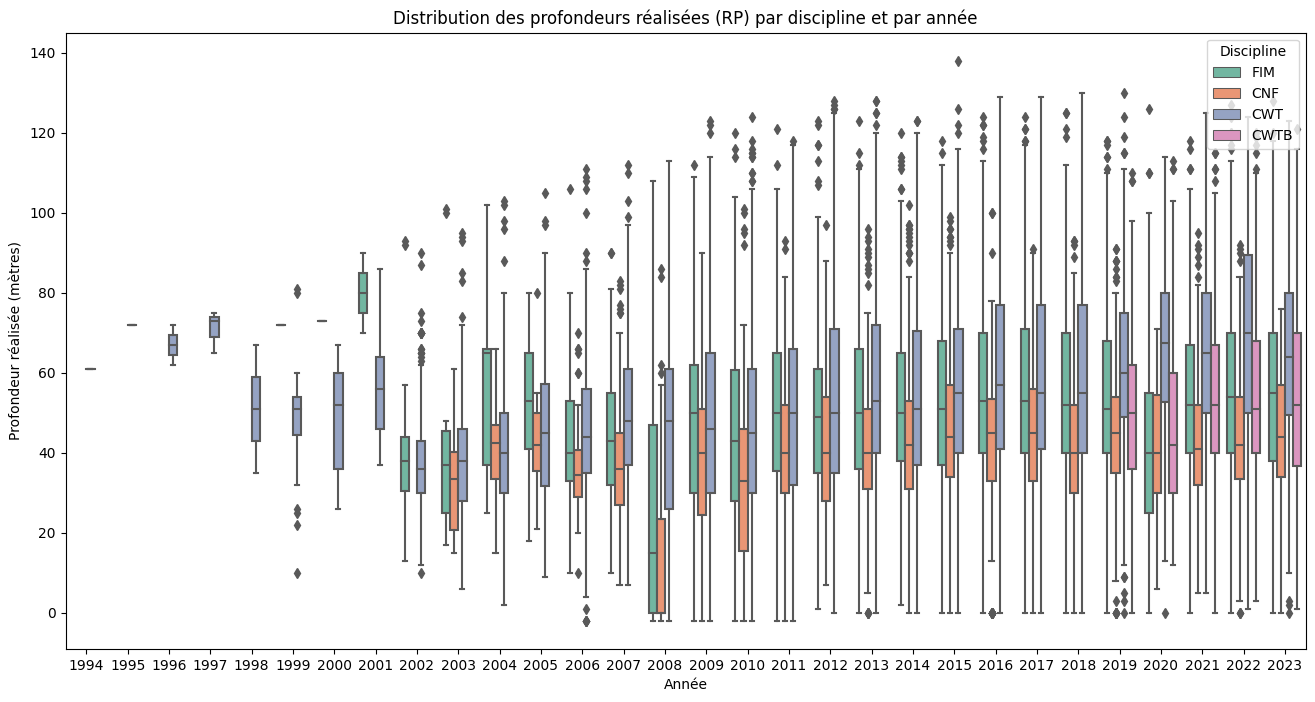

In [330]:
# Distribution des profondeurs réalisées (RP) par discipline et par année
plt.figure(figsize=(16, 8))
sns.boxplot(x='Year', y='RP', hue='Discipline', data=dataset, palette='Set2')
plt.title('Distribution des profondeurs réalisées (RP) par discipline et par année')
plt.xlabel('Année')
plt.ylabel('Profondeur réalisée (mètres)')
plt.legend(title='Discipline', loc='upper right')
plt.show()

On observe que la profondeur de plongée est constante au file des années, à l'exeption de 2008, accident peut-être.
Le graph nous permet aussi de nous rendre compte des periodes d'apparition des différentes catégories.

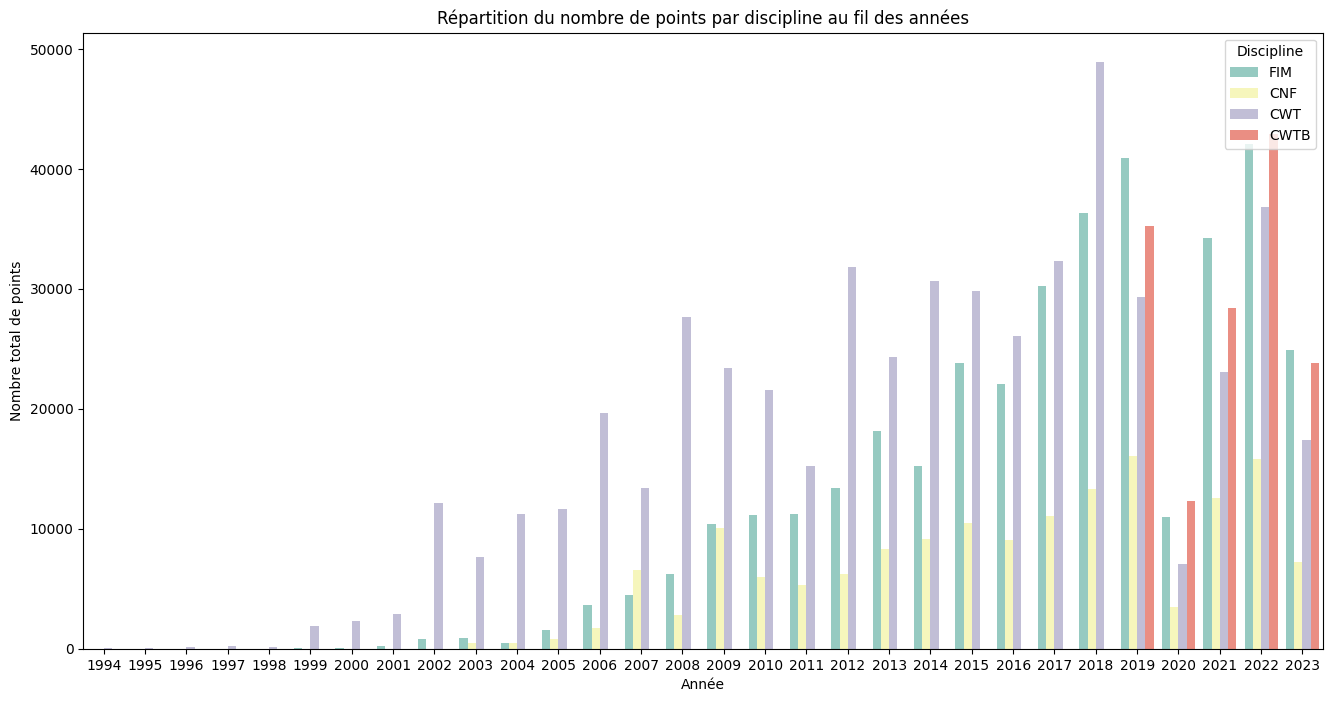

In [331]:
# Répartition du nombre de points par discipline au fil des années (diagramme en barres empilées)
plt.figure(figsize=(16, 8))
sns.barplot(x='Year',y=dataset['Points'].astype(float), hue='Discipline', data=dataset, errorbar=None, estimator=sum, palette='Set3')
plt.title('Répartition du nombre de points par discipline au fil des années')
plt.xlabel('Année')
plt.ylabel('Nombre total de points')
plt.legend(title='Discipline', loc='upper right')
plt.show()

En vue des graph précédents, on ne peut pas conclure sur la tendance de nos données. Cependant la catégorie CWT amasse plus de points en générale. Il faudrait regarder la proportion d'apnéistes dans chaque catégories pour savoir si il s'agit vraiment d'une superiorité ou du simple fait que plus d'individus participe dans la catégorie CWT.

# Clustering

### Transformation des données

#### Transformation des données catégoriques en numérique

In [332]:
dataset['Gender'] = dataset['Gender'].replace(('M', 'F'), (1,0)) # 1 remplace Male et 0 remplace Female

In [333]:
for element in dataset['Discipline'] .unique():
    dataset[element]= dataset['Discipline'].apply(lambda x: 1 if x == element else 0)

On remplace les noms par des int, en faisant 4 nouvelles colonnes de manière à éviter de donner de faux poids au catégories

In [334]:
dataset['Card'] = dataset['Card'].replace(('WHITE','YELLOW','RED'),(1,2,3)) # white :1 / yellow :2 / red :3

In [335]:
dataset['Event Type'] = dataset['Event Type'].replace(('Pool Competiton','Team Competition'), np.nan)
dataset['Event Type'] =dataset['Event Type'].dropna()

On retire Pool competition et Team competition puisque ininteressant pour notre étude

In [336]:
dataset['World record'] =dataset['Event Type'].apply(lambda x: 1 if x == 'worldrecord' else 0)

Creation d'une colonne world record pour en faire une catégorie a part entiere

#### Création de caractéristiques

On récupère le mois en considérant les données de Day en string pour séparer les élément et conserver seukement la partit qui donne le mois.

In [337]:
dataset['MONTH'] = dataset['Day'].str.split('-').str[1].astype(int)


In [338]:
dataset[(dataset['MONTH'] > 12) & (dataset['MONTH'] < 1)] # verification que les mois sont correcte 

Empty DataFrame
Columns: [Start, Diver, Gender, Discipline, Official Top, AP, RP, Card, Points, Remarks, Title Event, Event Type, Day, Category Event, Year, FIM, CNF, CWT, CWTB, World record, MONTH]
Index: []

[0 rows x 21 columns]

In [339]:
dataset['Day'] = pd.to_datetime(dataset['Day'])

# Trier le DataFrame par date
dataset.sort_values(by='Day', inplace=True)

# Expérience totale de plongée par athlète
experience_dive = dataset.groupby('Diver')['Day'].cumcount() + 1

# Expérience totale de plongée par athlète et par discipline
experience_discipline = dataset.groupby(['Diver', 'Discipline'])['Day'].cumcount() + 1

# Ajouter les colonnes d'expérience au DataFrame d'origine
dataset['experience_dive'] = experience_dive
dataset['experience_discipline'] = experience_discipline

dataset

Start                    Diver  Gender Discipline Official Top  AP  RP  \
8929       1    Deborah Andollo (CUB)       0        CWT        00:00  61  61   
3716       1  Umberto Pelizzari (ITA)       1        CWT        00:00  72  72   
3713       1    Deborah Andollo (CUB)       0        CWT        00:00  62  62   
5021       1      Michael Oliva (FRA)       1        CWT        00:00  72  72   
3717       1   Alejandro Ravelo (CUB)       1        CWT        00:00  73  73   
...      ...                      ...     ...        ...          ...  ..  ..   
26779      7  Alhadoom Almheiri (ARE)       1        CNF        19:33  30  28   
26780      8       Firas Fayyad (PSE)       1        CNF        19:41  30  30   
26781      9      Ahmed Abdulla (BHR)       1        CWT        19:49  41  41   
26782     10      Dmitry Kataya (INT)       1        FIM        19:57  37  37   
26783     11          Aws Lafta (IRQ)       1       CWTB        20:05  20  20   

       Card Points      Remarks  ... Category Event  Year FIM CNF  CWT  CWTB  \
8929      1   61.0           OK  ...          other  1994   0   0    1     0   
3716      1   72.0           OK  ...          other  1995   0   0    1     0   
3713      1   62.0           OK  ...          other  1996   0   0    1     0   
5021      1   72.0           OK  ...          other  1996   0   0    1     0   
3717      1   73.0           OK  ...          other  1997   0   0    1     0   
...     ...    ...          ...  ...            ...   ...  ..  ..  ...   ...   
26779     2   25.0  Rpap,no tag  ...          other  2023   0   1    0     0   
26780     1   30.0           Ok  ...          other  2023   0   1    0     0   
26781     1   41.0           Ok  ...          other  2023   0   0    1     0   
26782     1   37.0           Ok  ...          other  2023   1   0    0     0   
26783     1   20.0           Ok  ...          other  2023   0   0    0     1   

       World record  MONTH  experience_dive  experience_discipline  
8929              0      6                1                      1  
3716              0      9                1                      1  
3713              0     10                2                      2  
5021              0     10                1                      1  
3717              0      8                1                      1  
...             ...    ...              ...                    ...  
26779             0      7                2                      2  
26780             0      7                4                      1  
26781             0      7                2                      1  
26782             0      7                2                      1  
26783             0      7                3                      1  

[26672 rows x 23 columns]

#### Creation du dataframe

On enlève aussi Points et Remarks car ici notre IA cherchera a predire le carton et non les points ou remarques. \
On decide aussi de ne pas prendre en compte category event car tres semblable a event type. \
On ne prendra pas aussi l'année car d'aucune utilité.
Enfin, on retire RP qui esr une donnée de sortie.

In [340]:
df = dataset.drop(['Start','Diver', 'Title Event', 'Official Top', 'Day', 'Points', 'Remarks', 'Category Event', 'Year','RP','Discipline','Event Type'],axis=1)
df.index = [i for i in range(df.shape[0])]
df

Gender  AP  Card  FIM  CNF  CWT  CWTB  World record  MONTH  \
0           0  61     1    0    0    1     0             0      6   
1           1  72     1    0    0    1     0             0      9   
2           0  62     1    0    0    1     0             0     10   
3           1  72     1    0    0    1     0             0     10   
4           1  73     1    0    0    1     0             0      8   
...       ...  ..   ...  ...  ...  ...   ...           ...    ...   
26667       1  30     2    0    1    0     0             0      7   
26668       1  30     1    0    1    0     0             0      7   
26669       1  41     1    0    0    1     0             0      7   
26670       1  37     1    1    0    0     0             0      7   
26671       1  20     1    0    0    0     1             0      7   

       experience_dive  experience_discipline  
0                    1                      1  
1                    1                      1  
2                    2                      2  
3                    1                      1  
4                    1                      1  
...                ...                    ...  
26667                2                      2  
26668                4                      1  
26669                2                      1  
26670                2                      1  
26671                3                      1  

[26672 rows x 11 columns]

### Normalisation des données

On normalise avec $X_{normalisée} = \frac{X - X_{moyenne}}{X_{ecart-type}}$ toute les colonnes sauf Card puique label que l'on cherchera

In [342]:
cols_to_normalize = ['Gender', 'AP', 'MONTH', 'experience_dive', 'experience_discipline', 'World record', 'FIM', 'CNF', 'CWT', 'CWTB']
df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0)


In [343]:
#df[['Gender', 'AP', 'MONTH', 'experience_dive', 'experience_discipline','World record', 'FIM', 'CNF', 'CWT','CWTB']] = df.drop('Card', axis=1).apply(lambda x: (x - x.mean()) / x.std(), axis=0) 
#df.head(20)

### Recherche profil de plongée

#### Pour les carte rouges et toute les caractéristiques

In [344]:
# recuperation des données des plongeurs ayant obtenus une carte rouge
red_data = df[df['Card'] == 3].drop('Card',axis = 1)

In [345]:
red_data

Gender        AP       FIM       CNF       CWT      CWTB  \
1419  -1.365805 -0.054951 -0.655249 -0.468931  1.224990 -0.368307   
1420   0.732142 -1.072668 -0.655249 -0.468931  1.224990 -0.368307   
1850   0.732142 -2.260006 -0.655249 -0.468931  1.224990 -0.368307   
1855   0.732142 -2.260006 -0.655249 -0.468931  1.224990 -0.368307   
1868   0.732142  1.132387 -0.655249 -0.468931  1.224990 -0.368307   
...         ...       ...       ...       ...       ...       ...   
26629 -1.365805  0.241884 -0.655249  2.132428 -0.816303 -0.368307   
26633  0.732142  0.708338  1.526080 -0.468931 -0.816303 -0.368307   
26649  0.732142 -0.351785  1.526080 -0.468931 -0.816303 -0.368307   
26658  0.732142 -1.030263 -0.655249  2.132428 -0.816303 -0.368307   
26666  0.732142 -0.945454 -0.655249  2.132428 -0.816303 -0.368307   

       World record     MONTH  experience_dive  experience_discipline  
1419              0 -1.004819        -0.524686              -0.282974  
1420              0 -1.004819        -0.589243              -0.421676  
1850              0  1.527195        -0.589243              -0.560378  
1855              0  1.527195        -0.137342               0.271835  
1868              0  1.949198        -0.460129              -0.144272  
...             ...       ...              ...                    ...  
26629             0 -0.160814         1.218363               0.826643  
26633             0 -0.160814        -0.460129              -0.560378  
26649             0 -0.160814        -0.653801              -0.560378  
26658             0 -0.160814        -0.589243              -0.560378  
26666             0 -0.160814        -0.460129              -0.560378  

[2520 rows x 10 columns]

##### K-Means

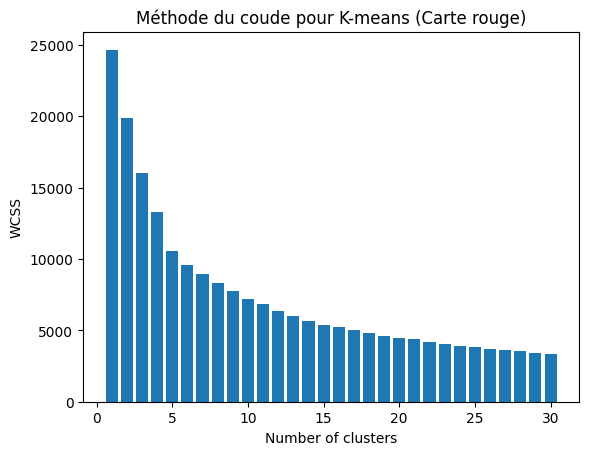

In [346]:
# utilisation de la methode du coude pour ressortir  le meilleur nombre de cluster possible
wcss = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(red_data)
    wcss.append(kmeans.inertia_)

# Visualisation de la methode du coude
plt.bar(range(1, 31), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Méthode du coude pour K-means (Carte rouge)')
plt.show()

on observe que selon la methode du coude le nombre de K optimal est de 10 puisque c'est l'endroit ou l'inertia est minimisée

In [347]:
# puisque en dessous de 10 cela ne descend plus abrutment comme avant
k_optimal = 10
kmeans_red = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
red_data_km = red_data.copy()
red_data_km['red_clusters'] = kmeans_red.fit_predict(red_data)

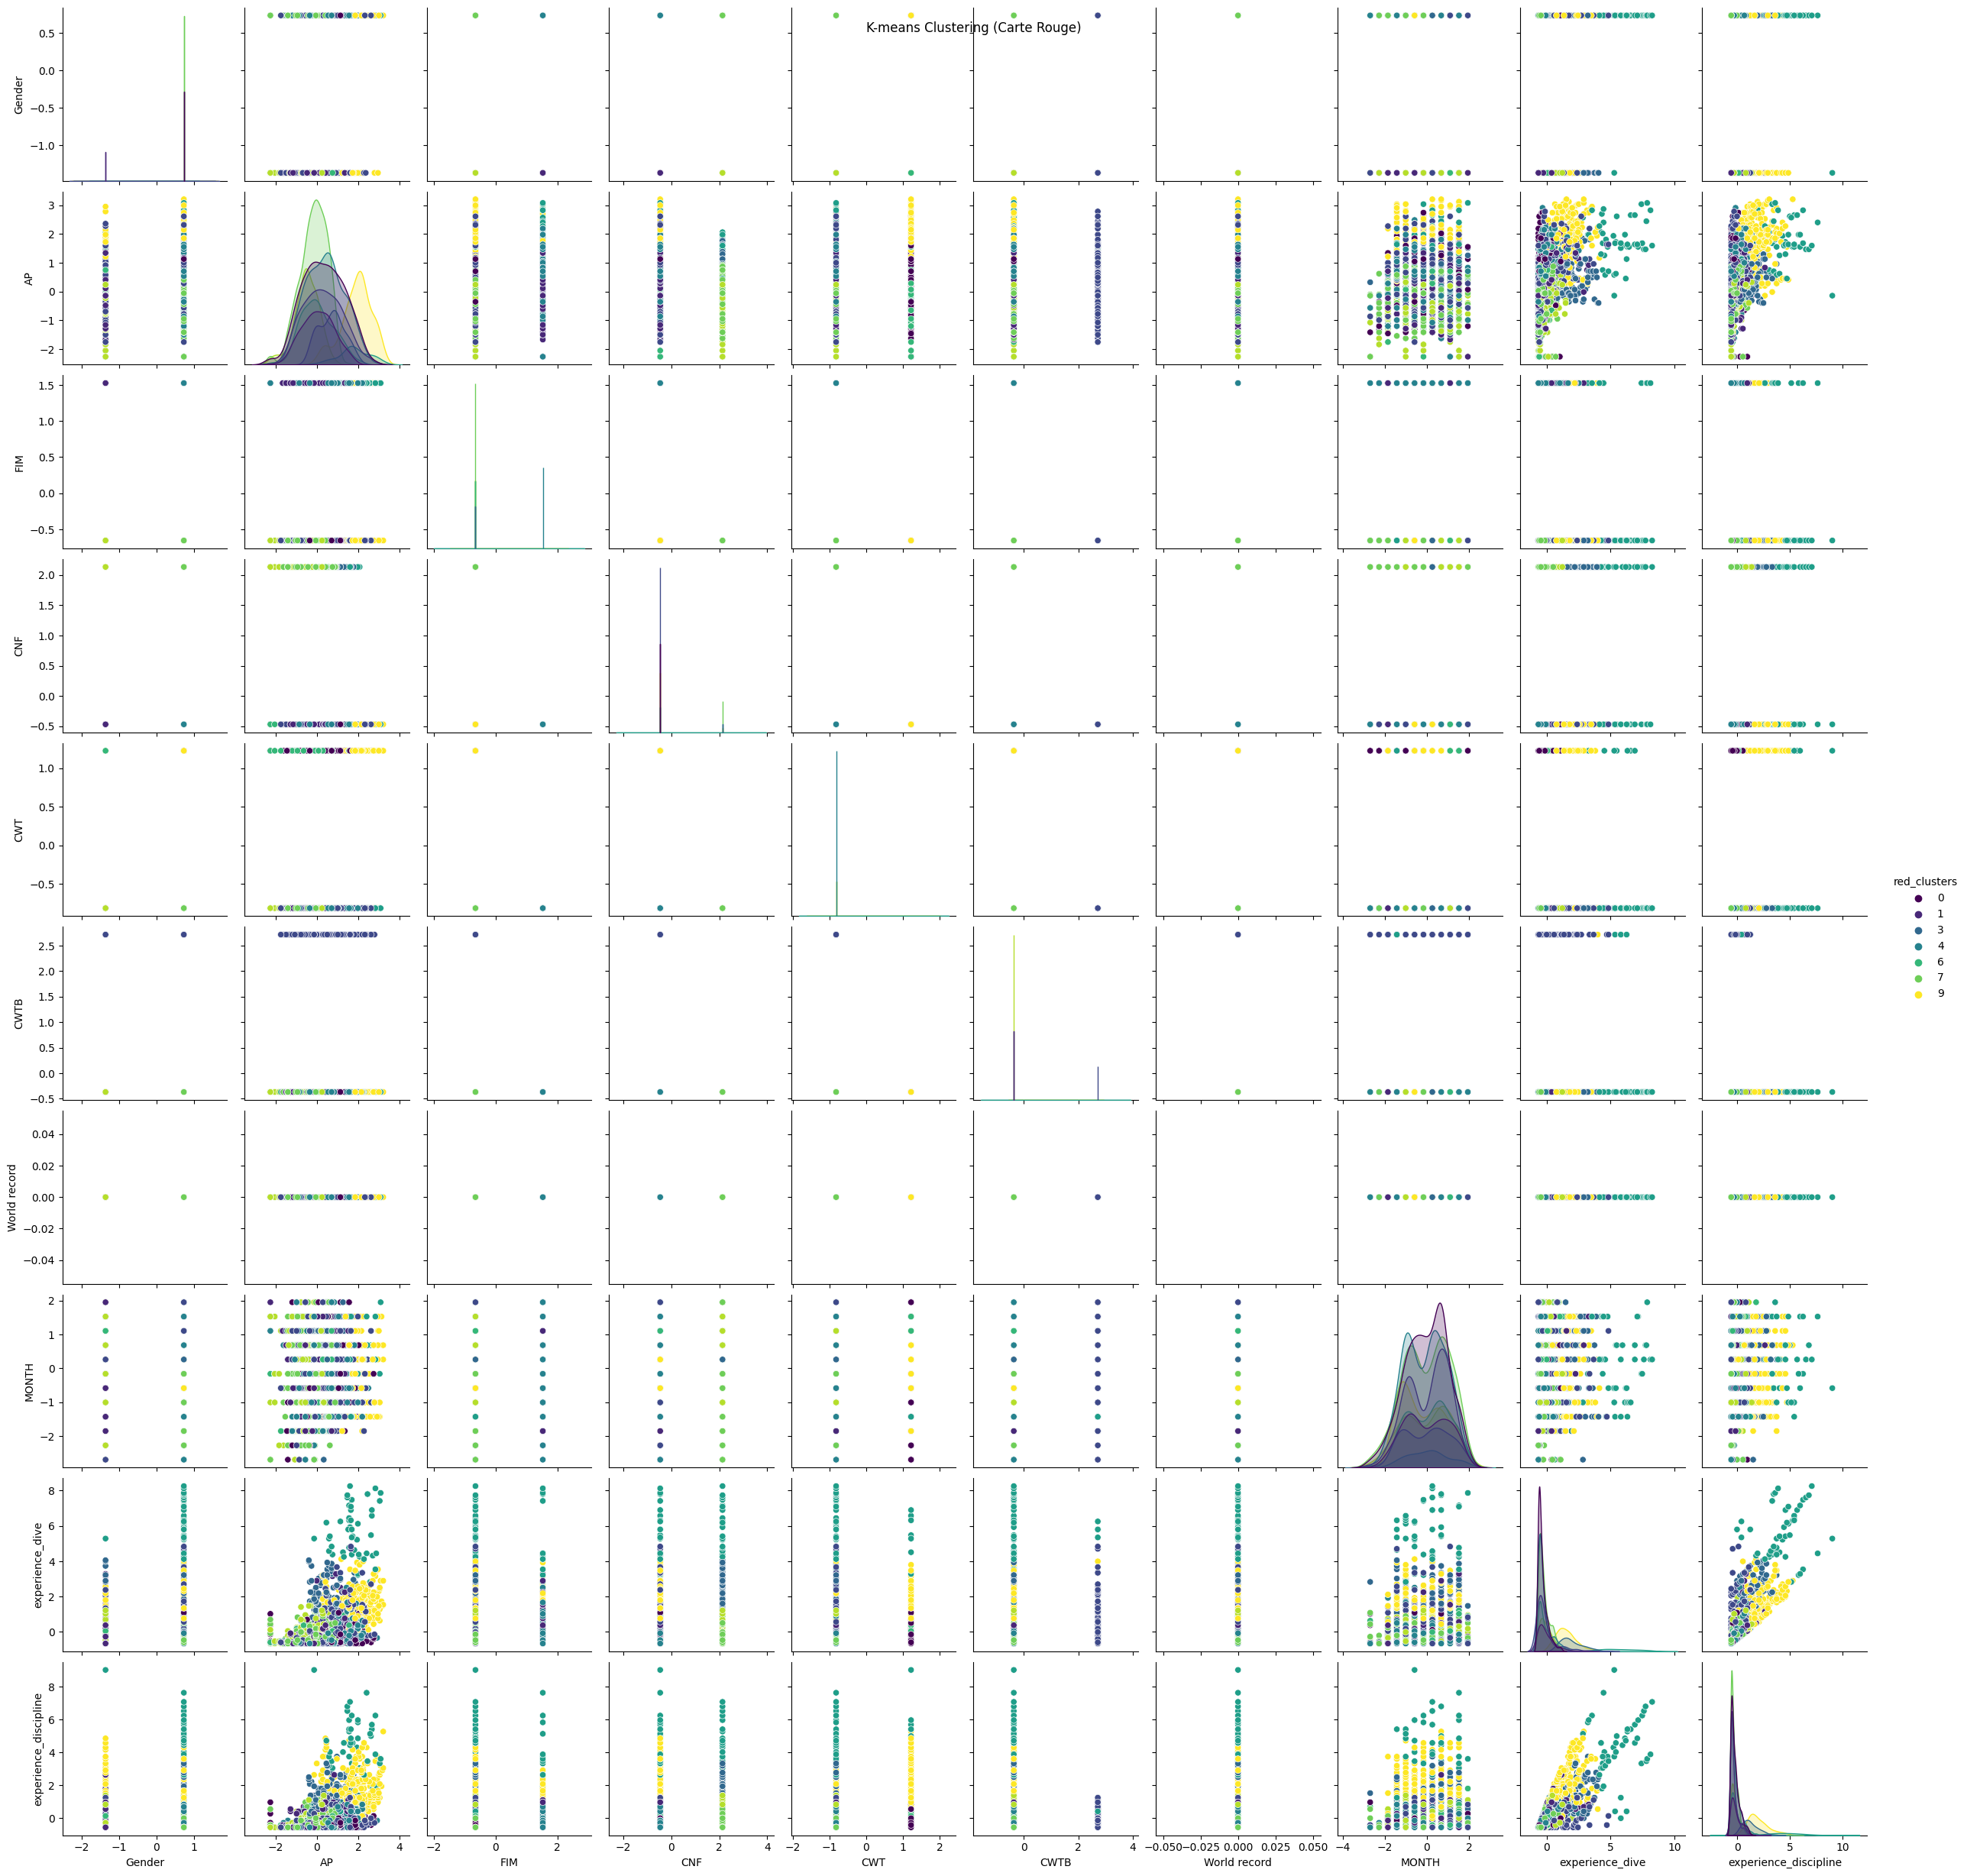

In [348]:
# Visualisation des resultat pour k_means 
sns.pairplot(red_data_km, hue='red_clusters', palette='viridis', diag_kind='kde')
plt.suptitle('K-means Clustering (Carte Rouge)')
plt.show()

Il est possible d'observer une forte corrélation entre RP et AP, ce qui est naturel puisque nous somme basés sur les les carton rouges qui ne montre que les échec de protocoles. 
Une autre corrélation importante se retrouve entre l'experience des plongeurs en général et dans une catégorie en particulier.

Les relation experience / profondeur est à remarquer. En effet, un groupe sort du lot par rapport au autre clusters.

##### DBSCAN

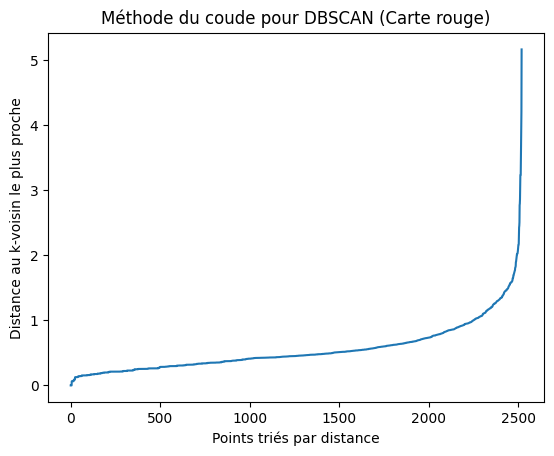

In [349]:
# Utilisation de la méthode du coude pour DBSCAN
min_samples = 5  # On prend un min de 5 
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(red_data)
distances, indices = nbrs.kneighbors(red_data)

# Triez les distances et utilisez le point de coude comme valeur pour eps
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel('Points triés par distance')
plt.ylabel('Distance au k-voisin le plus proche')
plt.title('Méthode du coude pour DBSCAN (Carte rouge)')
plt.show()


L'eps optimal est environ de 1.5 grâce à la méthode du coude, c'est lendroit où l'inertia est minimisé.

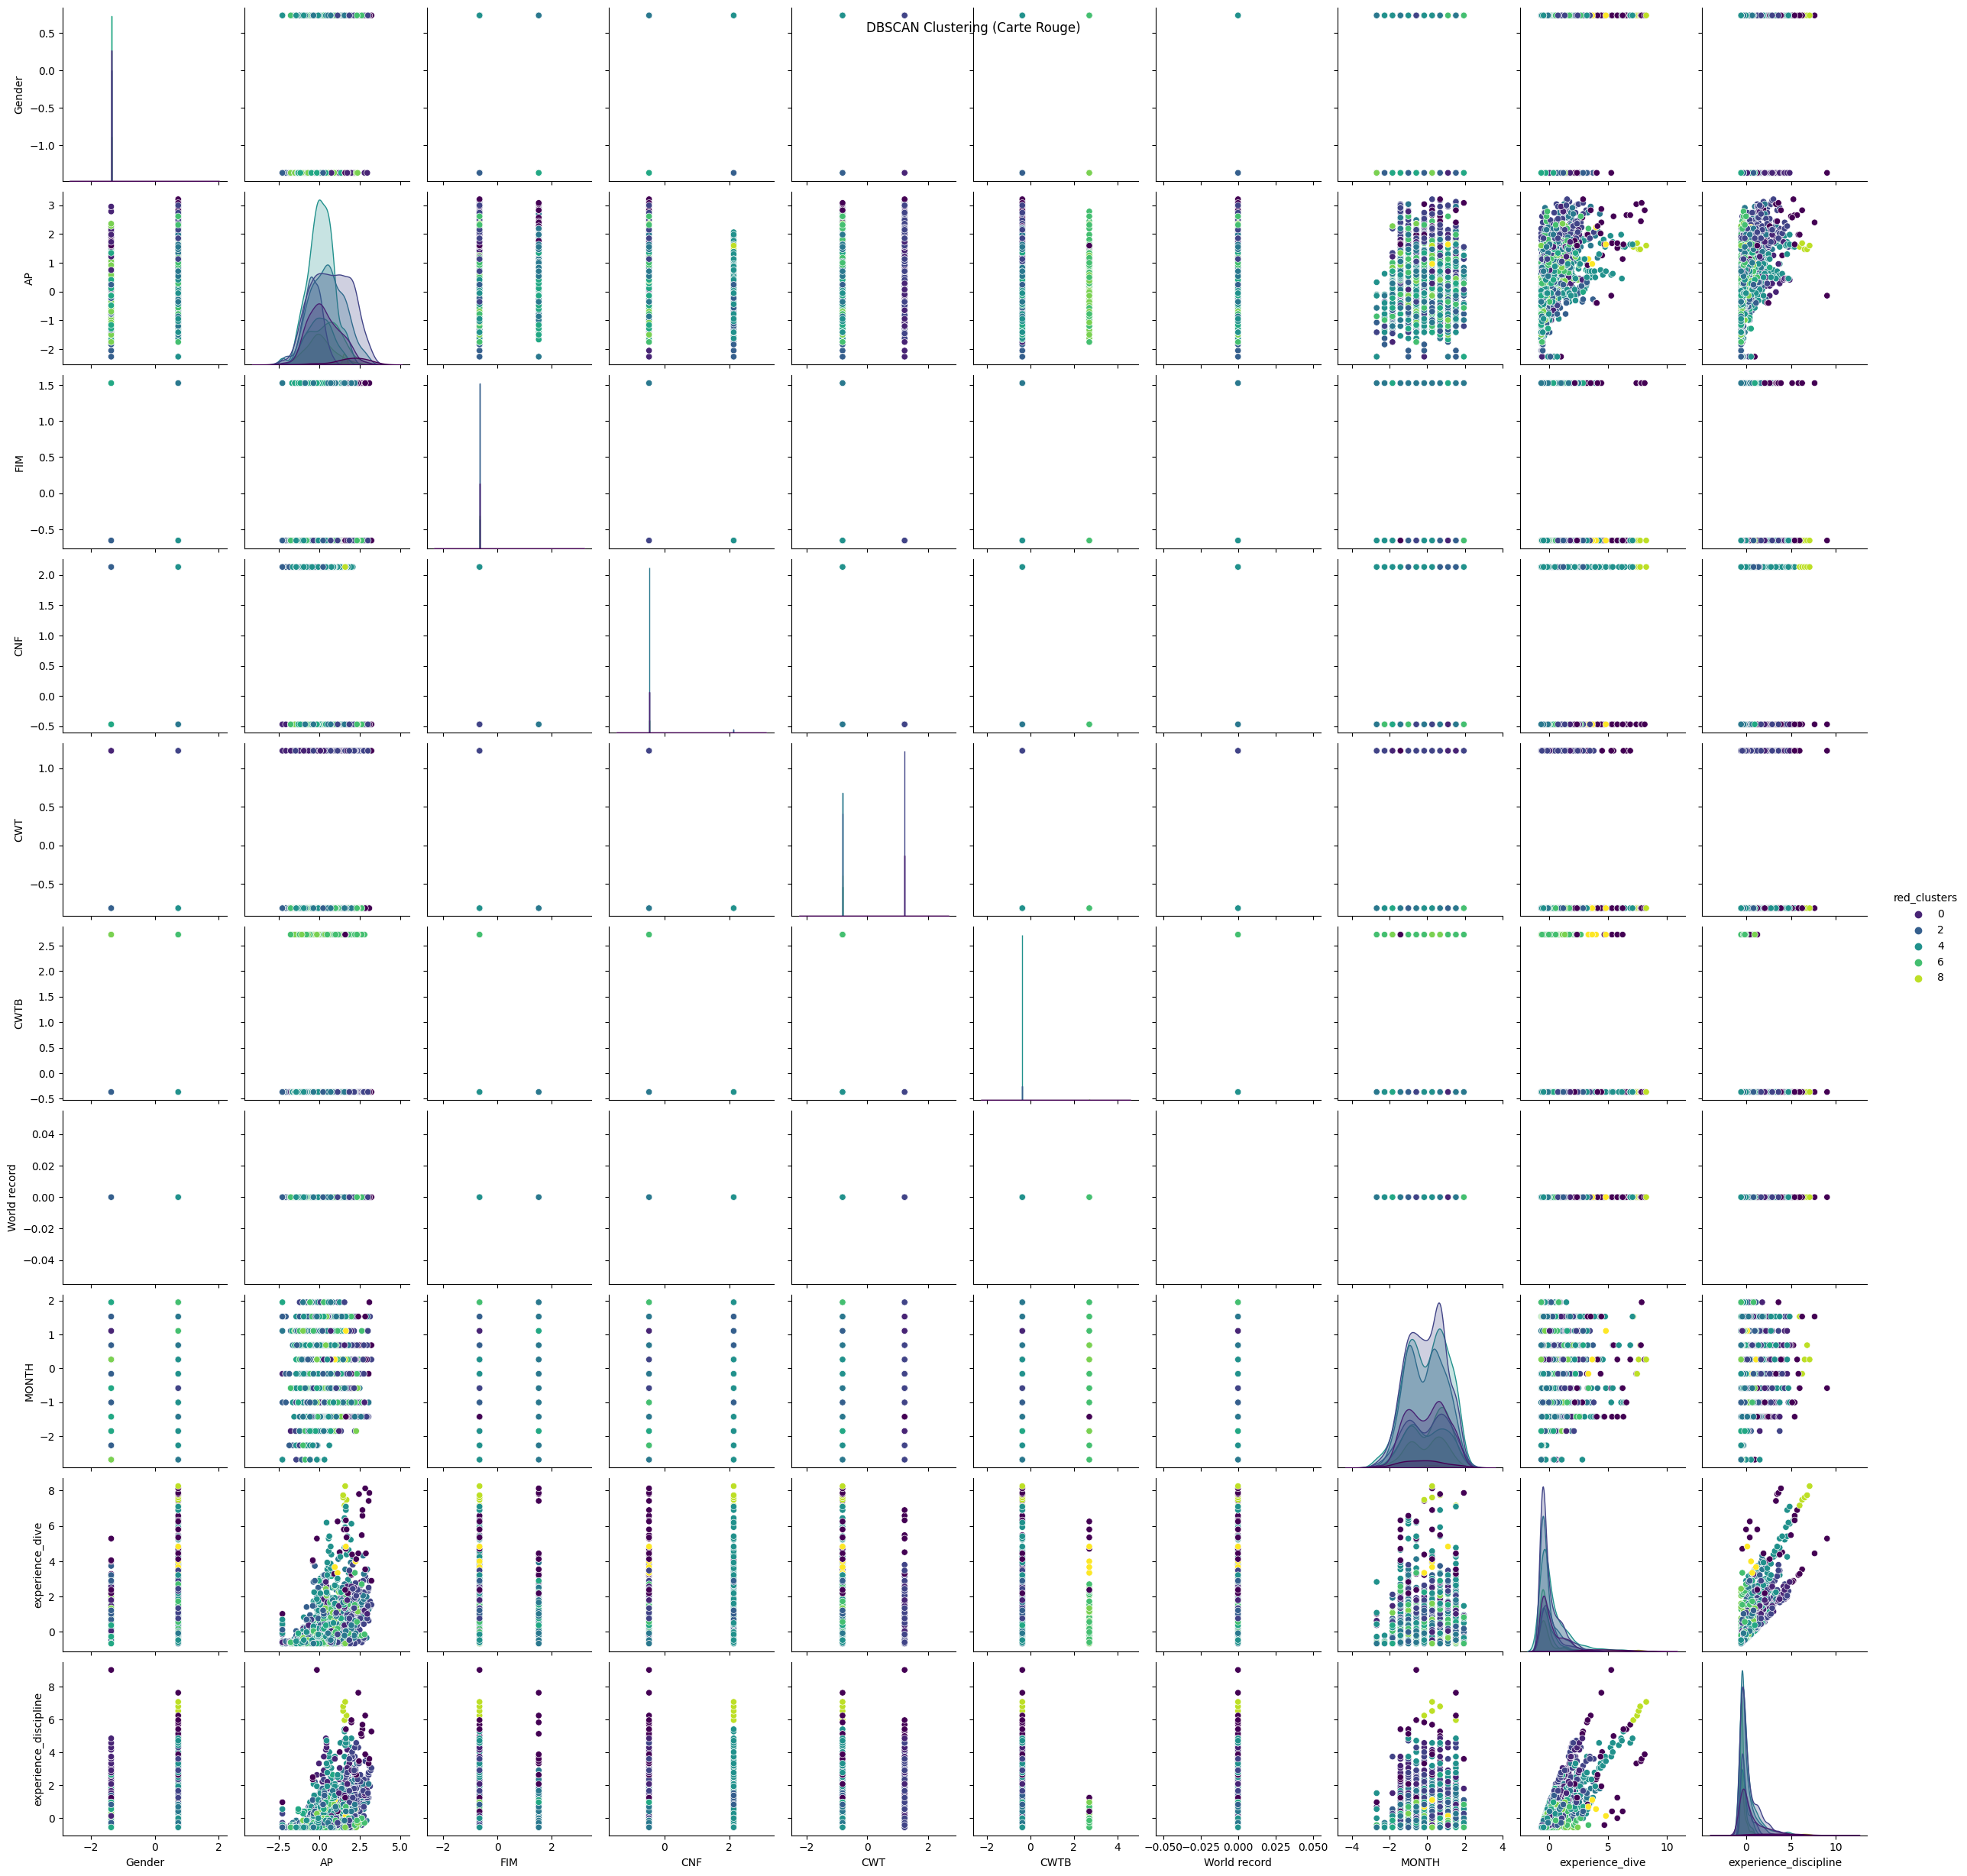

In [350]:
# On observe le point de coude a 1.5 environ sur le graphique si dessus
eps_optimal = 1.5  

# Appliquer DBSCAN avec eps optimal
dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
red_data_db = red_data.copy()
red_data_db['red_clusters'] = dbscan.fit_predict(red_data)

# Visualisation des résultats de DBSCAN
sns.pairplot(red_data_db, hue='red_clusters', palette='viridis', diag_kind='kde')
plt.suptitle('DBSCAN Clustering (Carte Rouge)')
plt.show()

Il est possible d'observer une forte corrélation entre RP et AP, ce qui est naturel puisque nous somme basés sur les les carton rouges qui ne montre que les échec de protocoles. 
Une autre corrélation importante se retrouve entre l'experience des plongeurs en général et dans une catégorie en particulier.

Les relation experience / profondeur est à remarquer. En effet, un groupe sort du lot par rapport au autre clusters.

Le DBSCAN ne donne donc pas de différence observable par rapport au K-means.

#### Pour les carte blanches et toute les caractéristiques

In [351]:
# recuperation des données des plongeurs ayant obtenus une carte blanche
white_data = df[df['Card'] == 1].drop('Card',axis = 1)

##### K-Means

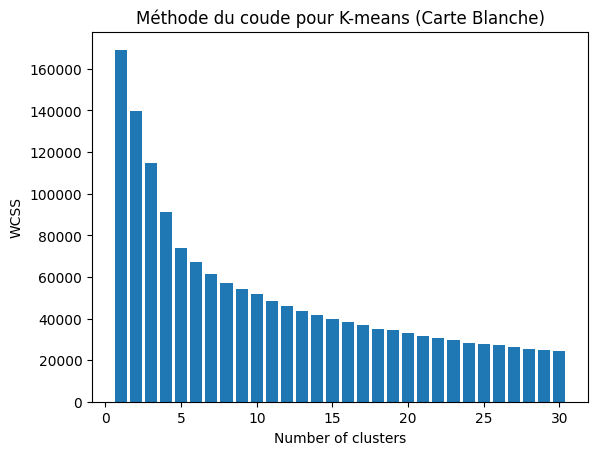

In [352]:
# utilisation de la methode du coude pour ressortir  le meilleur nombre de cluster possible
wcss = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(white_data)
    wcss.append(kmeans.inertia_)

# Visualisation de la methode du coude
plt.bar(range(1, 31), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Méthode du coude pour K-means (Carte Blanche)')
plt.show()

on observe que selon la methode du coude le nombre de K optimal est de 10 puisque c'est l'endroit ou l'inertia est minimisée

In [353]:
# on observe que selon la methode du coude le nombre de cluster optimal est de 10
# puisque en dessous de 10 cela ne descend plus abrutment comme avant
k_optimal = 10
kmeans_white = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
white_data_km = white_data.copy()
white_data_km['white_clusters'] = kmeans_white.fit_predict(white_data)

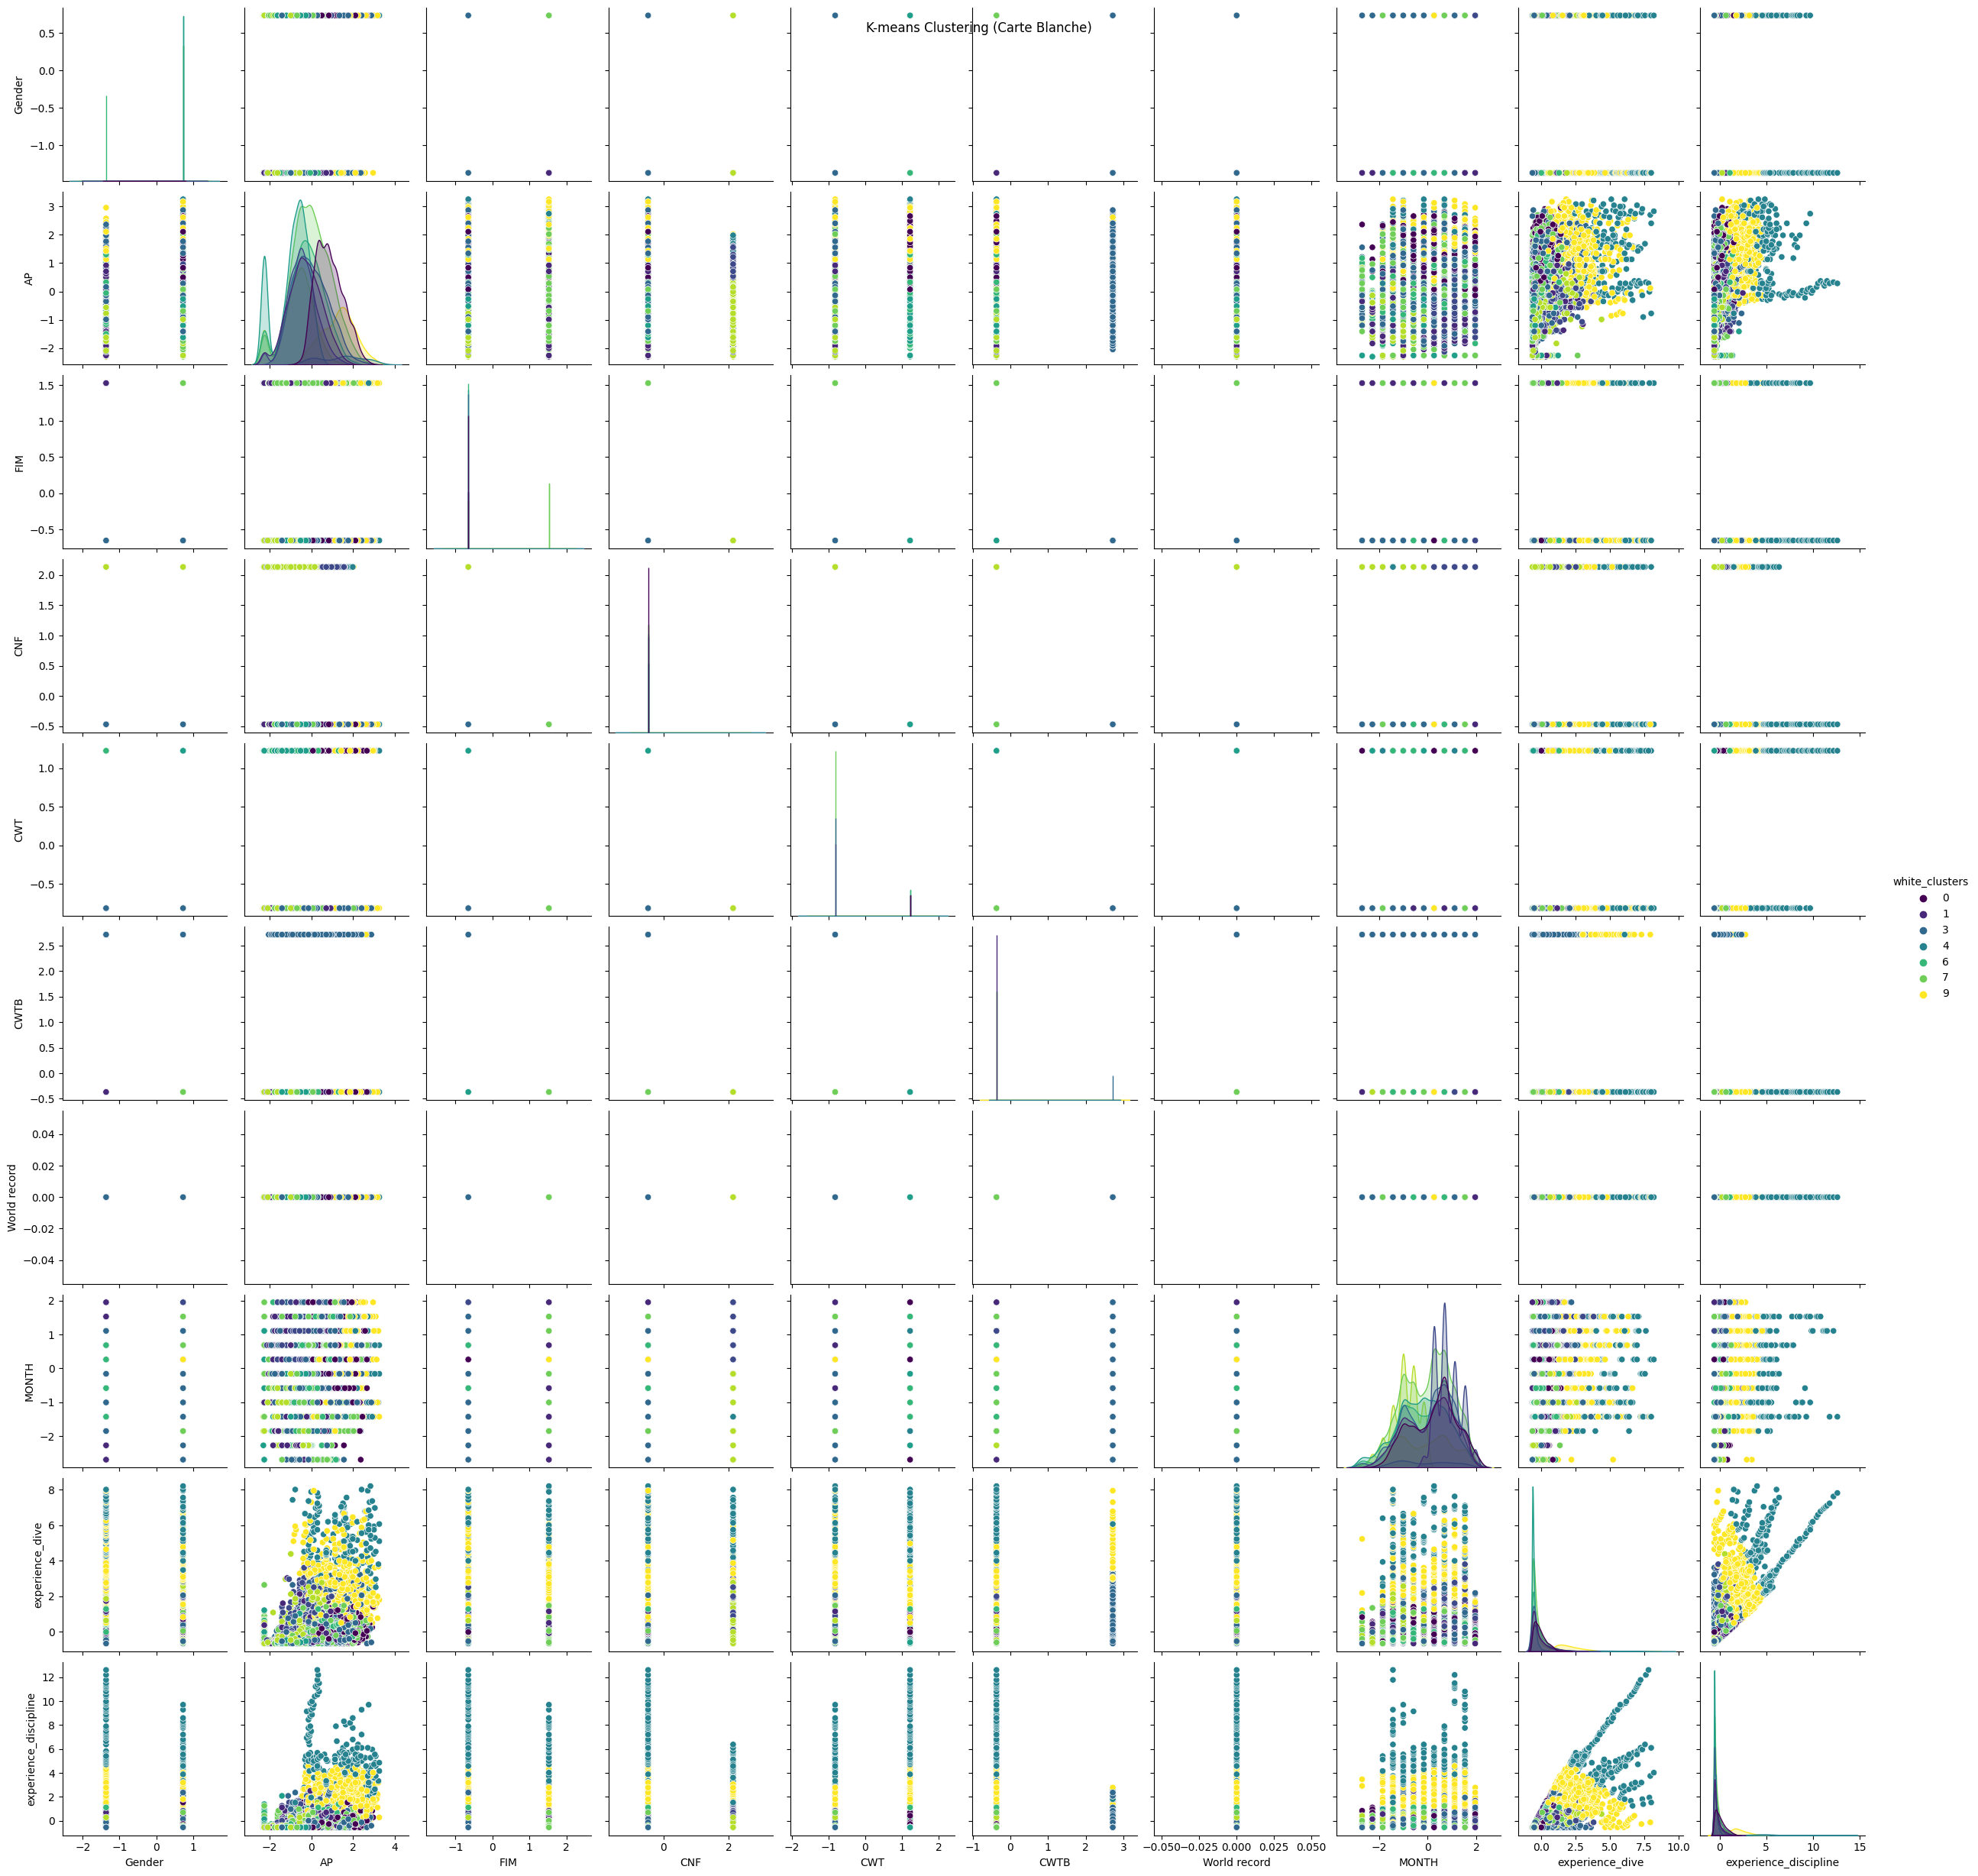

In [354]:
# Visualisation des resultat pour k_means 
sns.pairplot(white_data_km, hue='white_clusters', palette='viridis', diag_kind='kde')
plt.suptitle('K-means Clustering (Carte Blanche)')
plt.show()

Il est possible d'observer 4 graphs qui sortent un peu du lot. Les mêmes que pour les cartons rouges, cependant les relations experience / experience et experience / profondeur présentent des piques d'un même cluster qui par dans un ligne relativement droite. La relation entre les profondeurs montre une très forte corrélation, si on fait abstraction des valeurs impossibles sur les extremités. C'est rassurant puisque les plongeurs visent la profondeur qu'ils annoncent.

##### DBSCAN

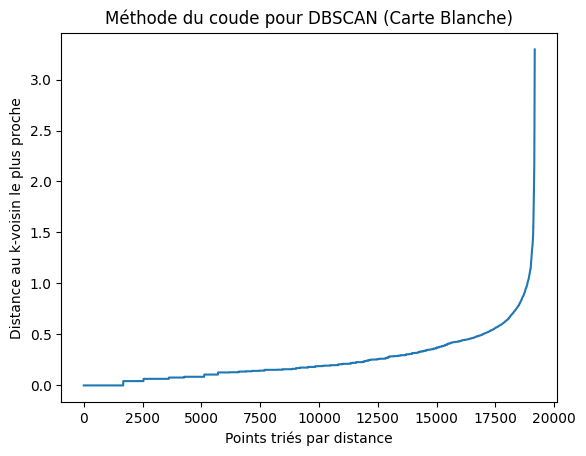

In [355]:
# Utilisation de la méthode du coude pour DBSCAN
min_samples = 5  # On prend un min de 5 
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(white_data)
distances, indices = nbrs.kneighbors(white_data)

# Triez les distances et utilisez le point de coude comme valeur pour eps
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel('Points triés par distance')
plt.ylabel('Distance au k-voisin le plus proche')
plt.title('Méthode du coude pour DBSCAN (Carte Blanche)')
plt.show()

L'eps optimal est environ de 0.8 grâce à la méthode du coude, c'est lendroit où l'inertia est minimisé.

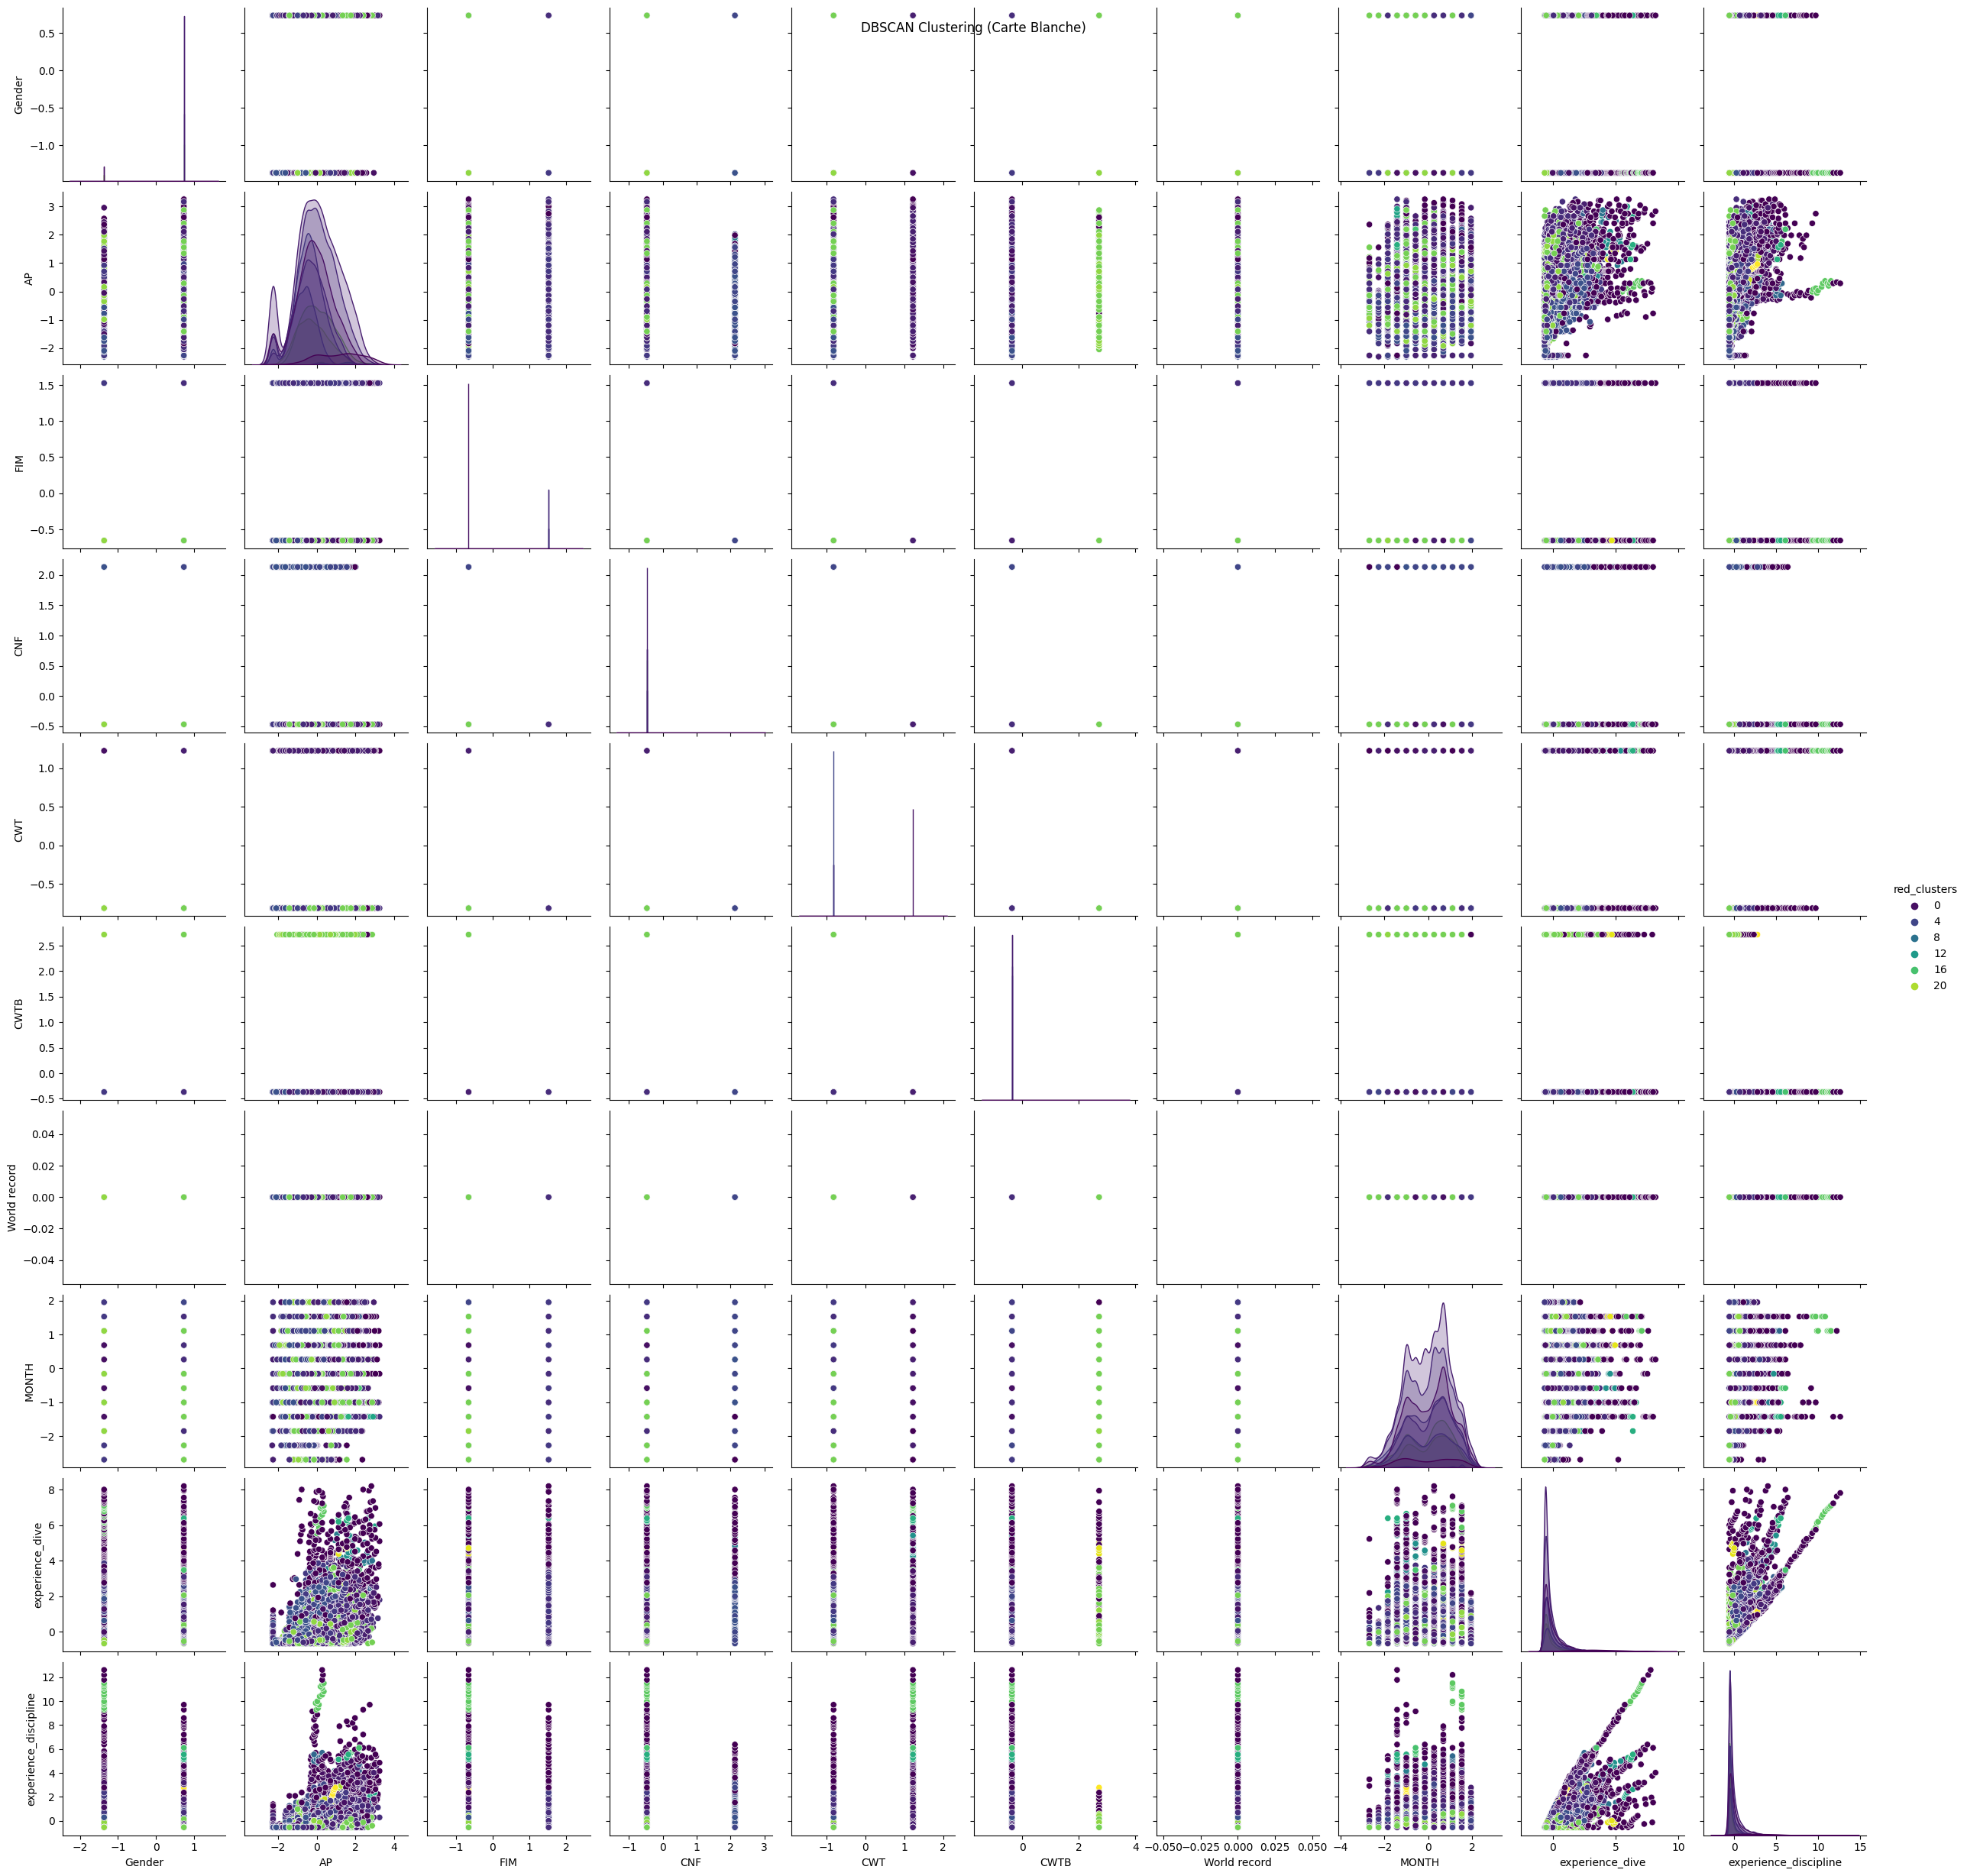

In [356]:
# On observe le point de coude a 0.8 environ sur le graphique si dessus
eps_optimal = 0.8  

# Appliquer DBSCAN avec eps optimal
dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
white_data_db = white_data.copy()
white_data_db['red_clusters'] = dbscan.fit_predict(white_data)

# Visualisation des résultats de DBSCAN
sns.pairplot(white_data_db, hue='red_clusters', palette='viridis', diag_kind='kde')
plt.suptitle('DBSCAN Clustering (Carte Blanche)')
plt.show()

Le DBSCAN des cartons blanc est extrêment similaire aux K-means correspondants. La différence se trouve dans la répartition des clusters qui est là beaucoup plus homogène.

https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd : source pour savoir trouver le bon eps-min

# Classification

In [357]:
# séparation des features et des labels
X = df.drop('Card', axis = 1)
y = df.Card

# separation entre les données d'entrainement et de test avec 30% des données pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Recherche du modele

In [358]:
# Créer et entraîner le modèle SVM avec différents noyaux
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    print(f"\nSVM avec noyau {kernel}:")
    
    # Créer le modèle SVM
    model = SVC(kernel=kernel, random_state=42)
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)
    
    # Évaluer la performance du modèle
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Précision : {accuracy:.2f}")
    
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))


SVM avec noyau linear:
Précision : 0.72
Matrice de confusion :
[[5751    0    0]
 [1485    0    0]
 [ 766    0    0]]

SVM avec noyau poly:
Précision : 0.72
Matrice de confusion :
[[5751    0    0]
 [1485    0    0]
 [ 766    0    0]]

SVM avec noyau rbf:
Précision : 0.72
Matrice de confusion :
[[5751    0    0]
 [1485    0    0]
 [ 766    0    0]]

SVM avec noyau sigmoid:
Précision : 0.65
Matrice de confusion :
[[5079  423  249]
 [1327  110   48]
 [ 670   62   34]]


In [359]:
# Création et test du modèle Naives Bayes meme si celui si est plus performant sur des données non corrélé
model = GaussianNB()  

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision : {accuracy:.2f}")

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Précision : 0.69
Matrice de confusion :
[[5387  224  140]
 [1327  125   33]
 [ 680   40   46]]


In [360]:
# Tester plusieurs valeurs de k_neighbors pour le modèle KNeighborsClassifier
for k_neighbors in range(1, 20):
    # Créer le modèle k-NN
    model = KNeighborsClassifier(n_neighbors=k_neighbors)

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Évaluer la performance du modèle
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Précision avec k={k_neighbors}: {accuracy:.2f}")
    
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))

Précision avec k=1: 0.59
Matrice de confusion :
[[4196 1024  531]
 [ 961  397  127]
 [ 520  139  107]]
Précision avec k=2: 0.68
Matrice de confusion :
[[5248  426   77]
 [1290  174   21]
 [ 671   72   23]]
Précision avec k=3: 0.66
Matrice de confusion :
[[4979  576  196]
 [1202  229   54]
 [ 626   92   48]]
Précision avec k=4: 0.68
Matrice de confusion :
[[5284  341  126]
 [1301  152   32]
 [ 662   66   38]]
Précision avec k=5: 0.69
Matrice de confusion :
[[5297  377   77]
 [1293  170   22]
 [ 673   63   30]]
Précision avec k=6: 0.69
Matrice de confusion :
[[5403  282   66]
 [1344  121   20]
 [ 691   49   26]]
Précision avec k=7: 0.70
Matrice de confusion :
[[5406  290   55]
 [1326  140   19]
 [ 696   48   22]]
Précision avec k=8: 0.70
Matrice de confusion :
[[5513  194   44]
 [1375   99   11]
 [ 713   33   20]]
Précision avec k=9: 0.70
Matrice de confusion :
[[5498  204   49]
 [1377  100    8]
 [ 708   37   21]]
Précision avec k=10: 0.70
Matrice de confusion :
[[5542  159   50]
 [1398

In [361]:
# Recherche des meilleurs parametres pour un modele SVC avec un kernel rbf
model = make_pipeline(SVC(kernel='rbf'))

# Définition de la distribution des valeurs pour chaque paramètre
param_distr = {
    'svc__C': [1,10,50,100,500,1000],
    'svc__gamma': [0.001,0.01,0.1,1,10] + ['auto', 'scale']
}

# Creation du model de recherche aléatoire
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distr,
    random_state=42,
    n_iter=10,
    cv=5
)

# entrainement du model de recherche avec X et y afin de trouver le meilleur modele
random_search.fit(X_train, y_train)

# recupère les meilleur paramètres et sont score
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = best_model.score(X_test, y_test)

best_model, best_params, best_score

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres:")
print(random_search.best_params_)

# Prédiction sur l'ensemble de test avec les meilleurs hyperparamètres
y_pred = random_search.predict(X_test)

# Évaluation des performances
accuracy = accuracy_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy}")

KeyboardInterrupt: 

Validation croisé 5 fois des paramètre du meilleurs model 

In [ ]:
# list de l'accuracy score du model
accuracy_cv = []

# init du KFold avec 5-fois
kfold = KFold(5)

# calcul de l'accuracy score basé sur la validation croisée 5 fois avec Kfold
for train_index, test_index in kfold.split(X,y):
    
    best_model.fit(X[X.index.isin(train_index)], y[y.index.isin(train_index)])
    
    accuracy_cv.append(best_model.score(X[X.index.isin(test_index)], y[y.index.isin(test_index)]))
    
accuracy_cv_array = np.array(accuracy_cv)

accuracy_cv_array.mean() # mean of 5 fold cross validate

0.862963809467584

In [ ]:
# Prediction de X_test basé sur les meilleurs models
prediction = best_model.predict(X_test)

# Creation et affichage de la matrice de confusion
cm = confusion_matrix(y_test, prediction)
ConfusionMatrixDisplay(cm).plot()

NameError: name 'best_model' is not defined